# Show how increasing dimensionality helps classification

In [1]:
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from random import shuffle

# Get the data

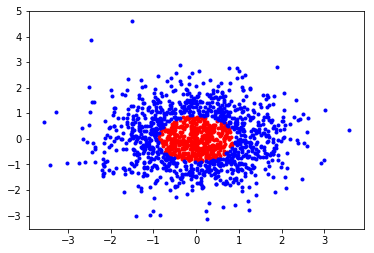

In [2]:
# number of features in
nf   = 2
# number of classes
nClass = 2

X = torch.randn(2,1500)
R = torch.sqrt(X[0,:]**2 + X[1,:]**2)
indRed   = (R < 0.9).nonzero()
indBlue  = (R >= 0.9).nonzero()


C = torch.zeros(1500,dtype = torch.int64)
C[indRed]  = 0
C[indBlue] = 1

plt.plot(X.numpy()[0,indRed],X.numpy()[1,indRed],'.r')
plt.plot(X.numpy()[0,indBlue],X.numpy()[1,indBlue],'.b')


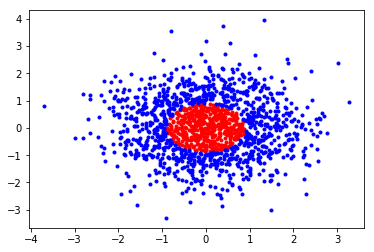

In [3]:
# Get a validation set
XVal = torch.randn(2,1500)
R = torch.sqrt(XVal[0,:]**2 + XVal[1,:]**2)
indRed   = (R < 0.9).nonzero()
indBlue  = (R >= 0.9).nonzero()


CVal = torch.zeros(1500,dtype = torch.int64)
CVal[indRed]  = 0
CVal[indBlue] = 1

plt.plot(XVal.numpy()[0,indRed],XVal.numpy()[1,indRed],'.r')
plt.plot(XVal.numpy()[0,indBlue],XVal.numpy()[1,indBlue],'.b')

# Design the simple ResNet

In [4]:
lossFunc = nn.CrossEntropyLoss()

def misfit(X,W,bias,C):
    n = W.shape
    X = X.view(n[1],-1)
    S = torch.matmul(W,X) 
    S += bias.unsqueeze(1)
    return lossFunc(S.t(),C)

In [6]:
class RK4Net(nn.Module):

    def __init__(self,NetGeo):
        super().__init__()
        
        self.NetGeo = NetGeo
        
    def forward(self,x,K0,K,b):
        dt = self.NetGeo[1]
        nt = self.NetGeo[0]
        
        # First layer open up
        #x = F.relu(torch.matmul(K0,x) + b[0])
        x = torch.matmul(K0,x)
        
        # Allocate space for all times
        X  = torch.zeros(x.shape[0],x.shape[1],nt+1)
        X[:,:,0] = x
        
        # forward Euler (to be improved later)
        for i in range(nt):
            k1 = F.relu(torch.matmul(K[i],x) + b[i])
            k2 = F.relu(torch.matmul(K[i],x+k1/2.0) + b[i])
            k3 = F.relu(torch.matmul(K[i],x+k2/2.0) + b[i])
            k4 = F.relu(torch.matmul(K[i],x+k3) + b[i])
            
            x = x + dt/6.0*(k1+k2+k3+k4)
            ind = i+1
            X[:,:,ind] = x
            
            
        return x,X 


# Initialize all parameter

In [9]:
dt = 0.05
nt = 100
nfNet = 16
NG    = [nt,dt]
net   = RK4Net(NG)

# initialize K's
K0  = nn.Parameter(torch.randn(nfNet, nf))
K = []
for i in range(nt):
    Ki  = nn.Parameter(torch.randn(nfNet, nfNet)*1e-3)
    K.append(Ki)
    
b  = nn.Parameter(torch.randn(nt)*1e-3)
        

In [10]:
# Run the network
xF,Xpath = net(X,K0,K,b)

In [12]:

# weights for linear classifier    
W      = nn.Parameter(torch.randn(nClass,nfNet)*1e-3,requires_grad=True)
bW     = nn.Parameter(torch.randn(nClass)*1e-2,requires_grad=True)

nparout = np.prod(K0.shape) + np.prod(W.shape) + np.prod(bW.shape) + np.prod(K[0].shape)*nt + nt

print('Total number of parameter',nparout)
print('Total number of data',C.shape[0])

Total number of parameter 25766
Total number of data 1500


In [13]:
# run the network
x,_ = net(X,K0,K,b)
label = C
print(W.shape)
loss = misfit(x,W,bW,label)
print('Initial loss = ', loss.detach().numpy())    
print('Sanity Check = ',np.log(2.0))

torch.Size([2, 16])
Initial loss =  0.6939026
Sanity Check =  0.6931471805599453


In [14]:
batchSize = 16

In [15]:
import torch.optim as optim
optimizer = optim.SGD([{'params': W},{'params': K},{'params': bW},{'params': b}], lr = 1e-1,momentum=0.0)

In [16]:
for epoch in range(30):  # loop over the dataset multiple times

    # zero the parameter gradients
    g = 0.0
    loss = 0.0
    ind = 0
    while ind<X.shape[1]:    
        optimizer.zero_grad()
        # get the inputs
        inputs = X[:,ind:ind+batchSize]
        labels = C[ind:ind+batchSize]

        # forward 
        x,_   = net(inputs,K0,K,b)
        lossi = misfit(x,W,bW,labels)
        if i==0:
            loss = lossi
        else:
            loss  += lossi
            
        lossi.backward()
        optimizer.step()
        g += torch.norm(W.grad) + torch.norm(bW.grad)    
        ind += batchSize
        
    print('%d  %.3f   %.3f'% (epoch+1, loss, g))

print('Finished Training')

1  64.138   100.902
2  61.646   87.191
3  53.075   68.560
4  38.993   49.432
5  28.767   38.370
6  22.657   32.168
7  18.856   28.519
8  16.305   26.160
9  14.477   24.464
10  13.098   23.137
11  12.020   22.069
12  11.150   21.192
13  10.432   20.445
14  9.827   19.797
15  9.309   19.232
16  8.859   18.729
17  8.464   18.277
18  8.114   17.870
19  7.801   17.501
20  7.518   17.161
21  7.261   16.849
22  7.027   16.559
23  6.812   16.289
24  6.615   16.037
25  6.431   15.797
26  6.261   15.574
27  6.103   15.362
28  5.955   15.160
29  5.816   14.967
30  5.686   14.784
Finished Training


# Plot the results on validation

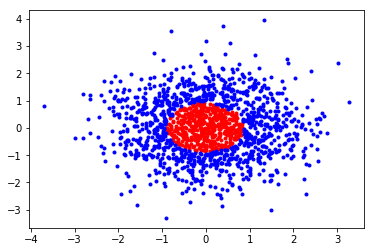

In [17]:
x,_      = net(XVal,K0,K,b)
S      = torch.matmul(W,x)
S     += bW.unsqueeze(1)
_,Cpred = torch.max(S,dim=0)


indRed   = (Cpred==0).nonzero()
indBlue  = (Cpred==1).nonzero()


plt.plot(XVal[0,indRed].numpy(),XVal[1,indRed].numpy(),'.r')
plt.plot(XVal[0,indBlue].numpy(),XVal[1,indBlue].numpy(),'.b')


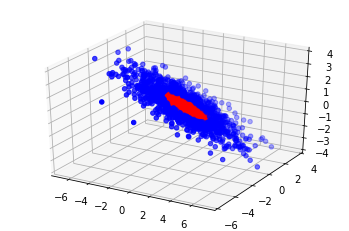

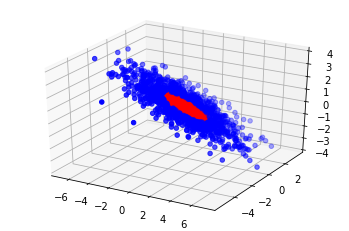

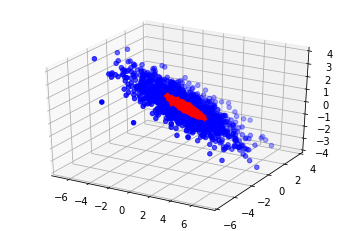

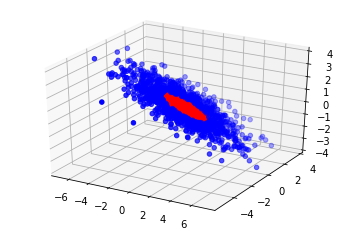

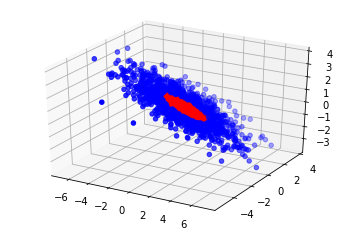

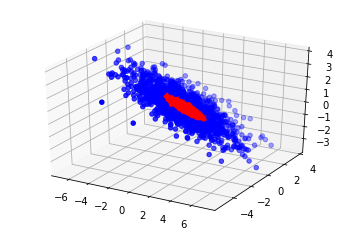

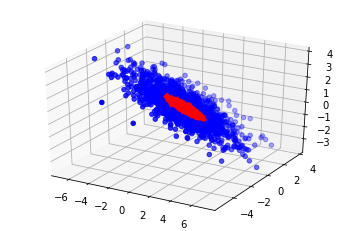

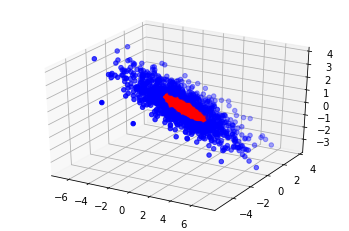

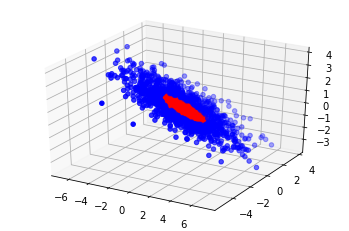

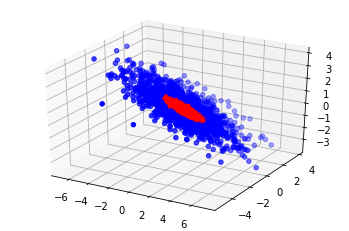

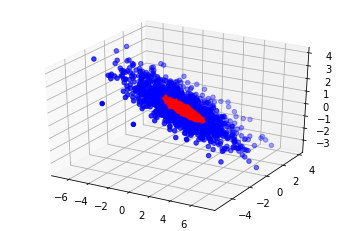

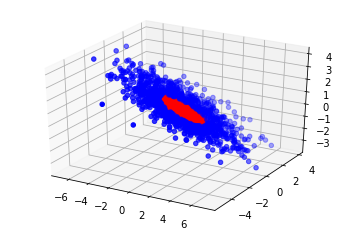

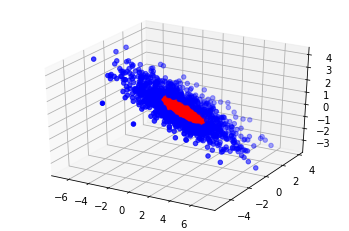

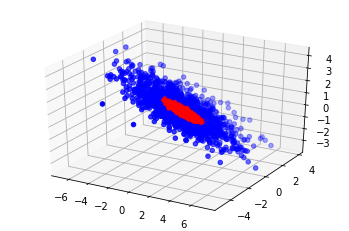

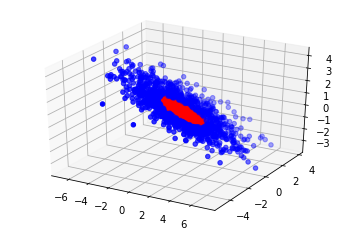

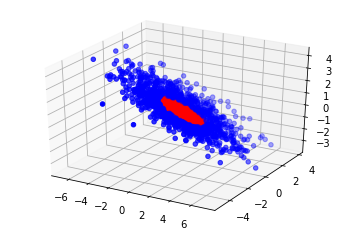

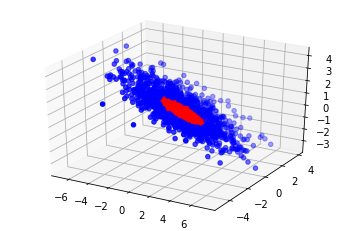

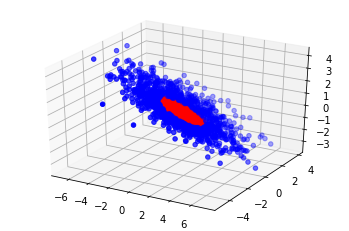

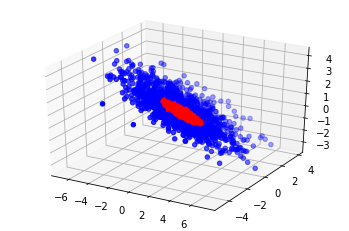

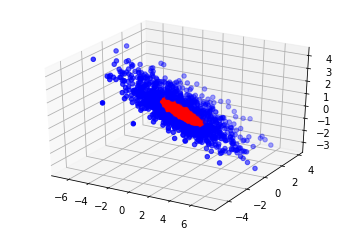

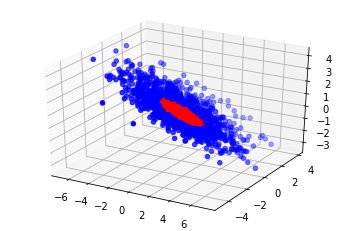

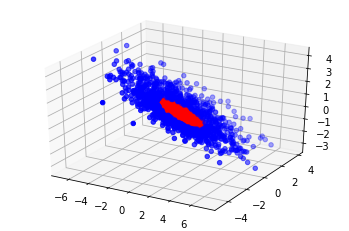

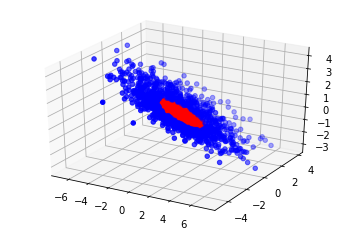

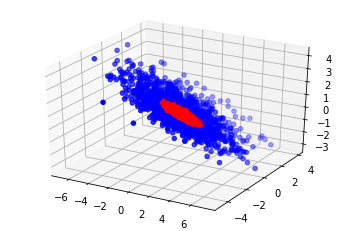

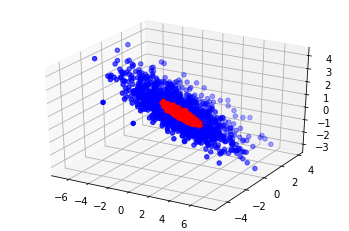

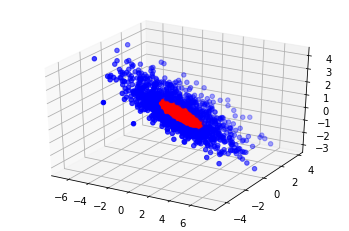

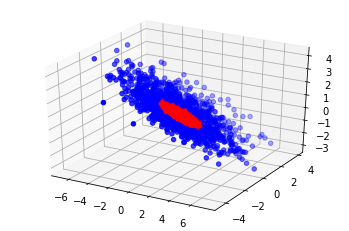

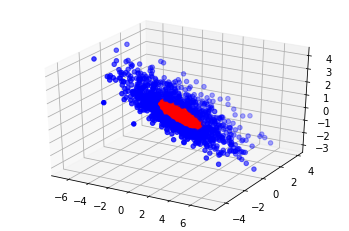

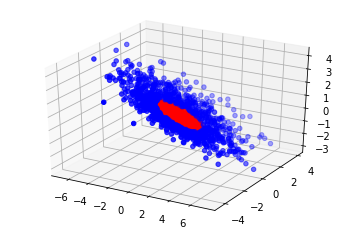

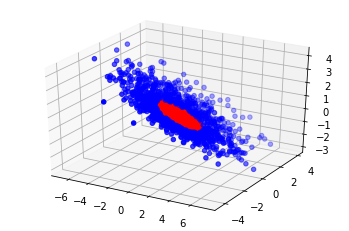

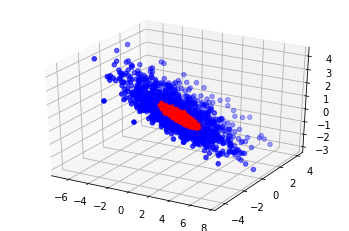

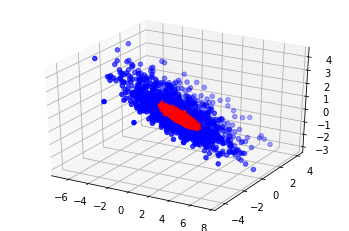

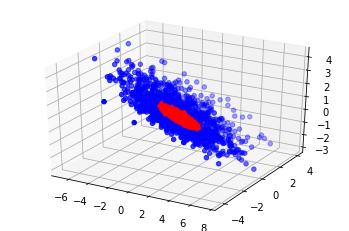

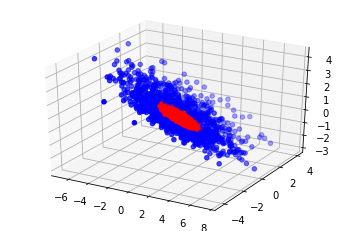

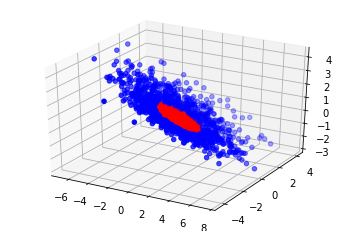

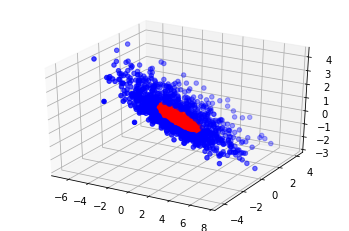

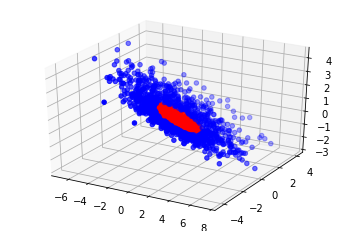

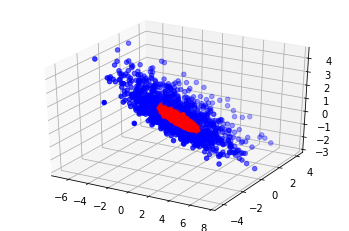

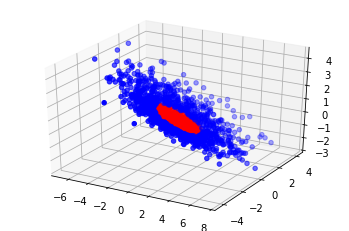

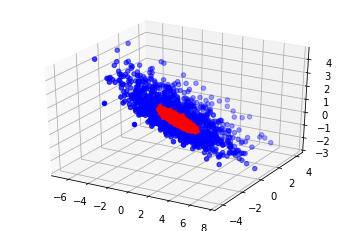

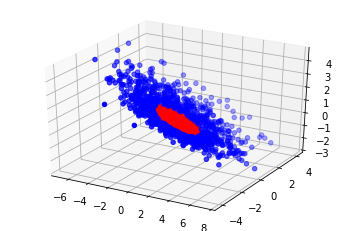

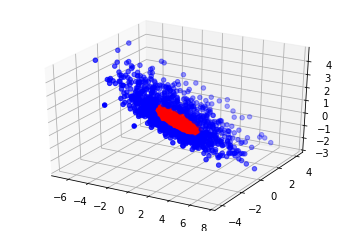

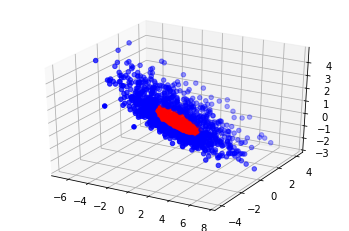

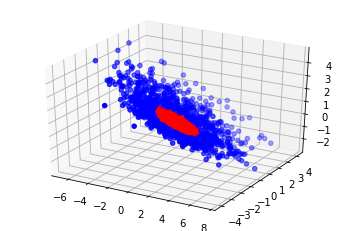

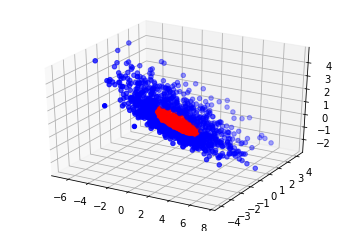

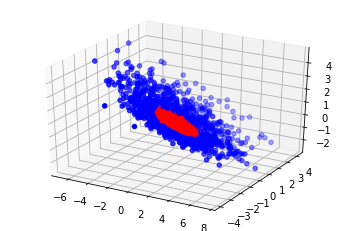

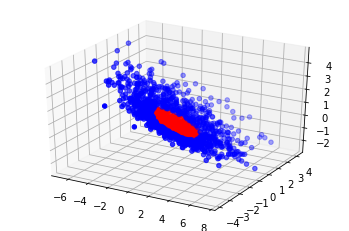

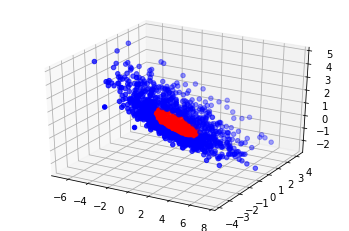

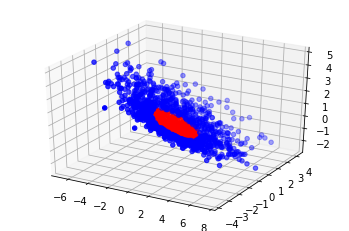

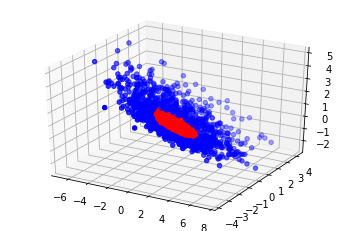

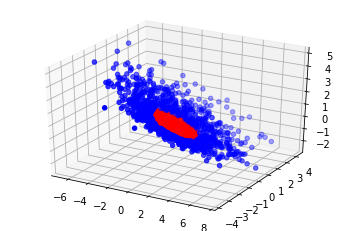

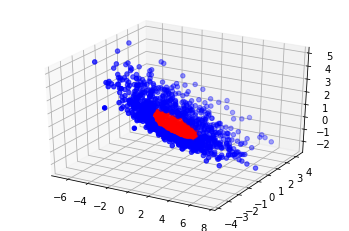

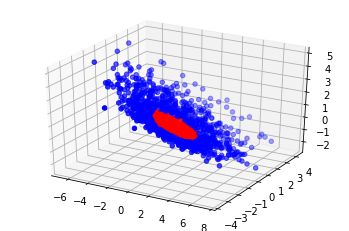

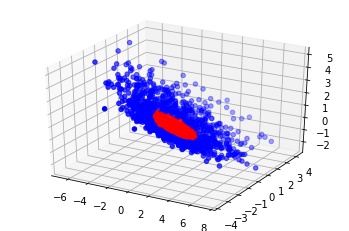

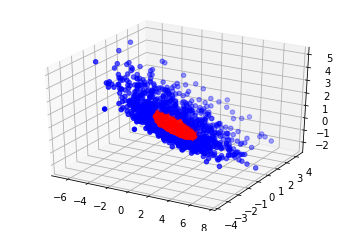

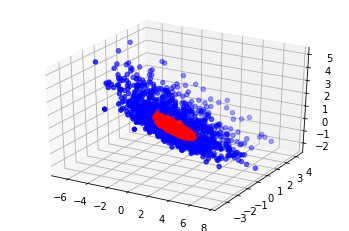

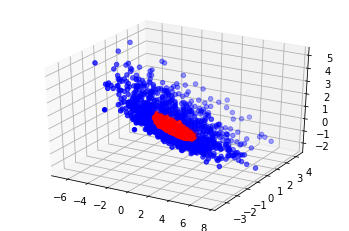

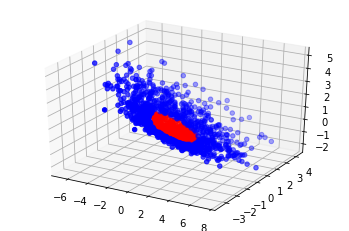

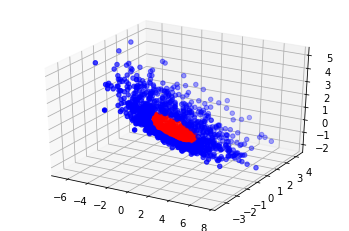

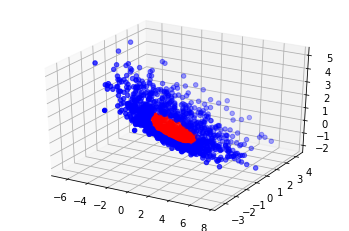

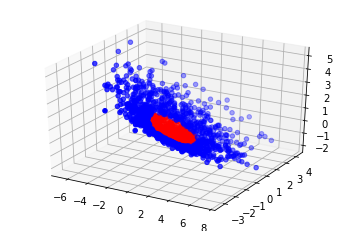

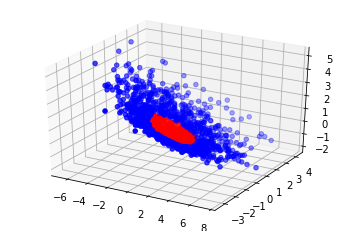

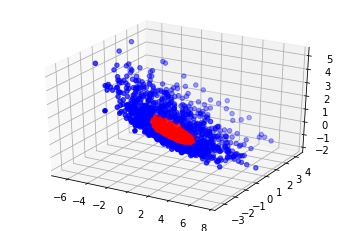

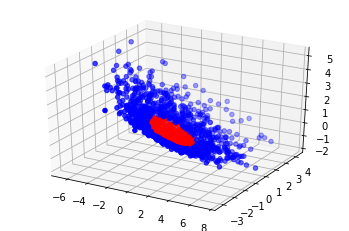

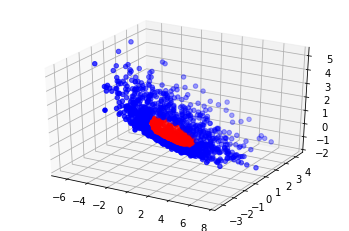

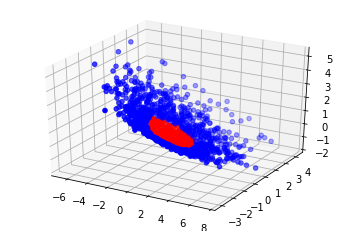

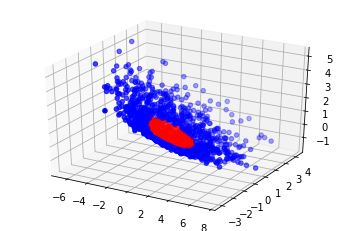

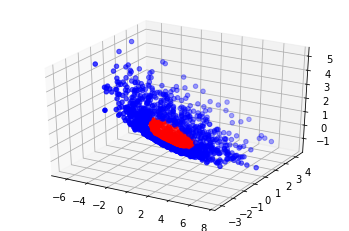

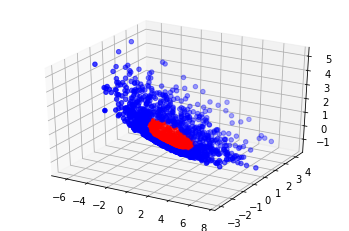

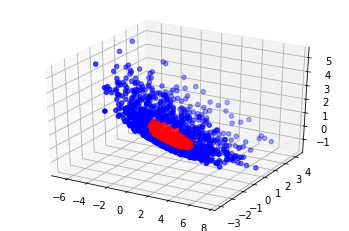

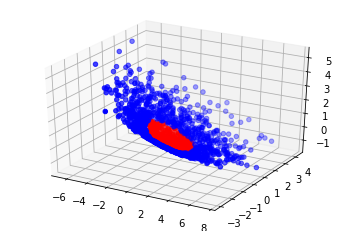

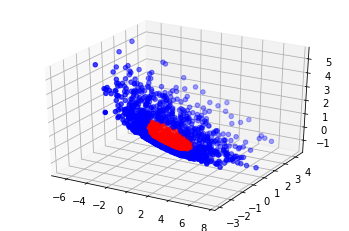

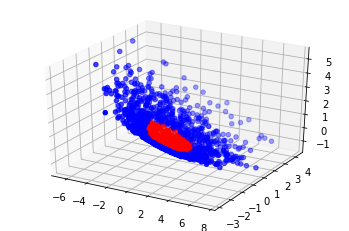

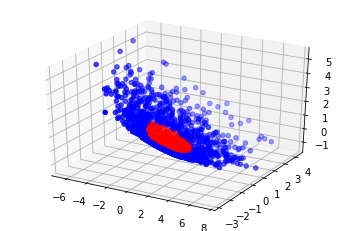

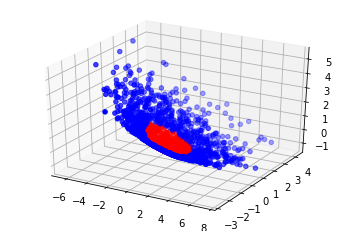

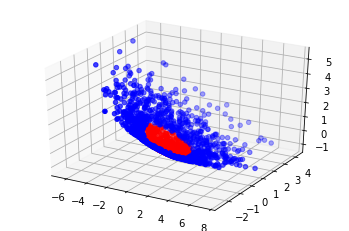

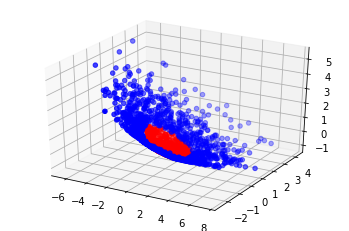

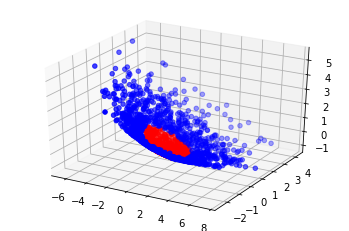

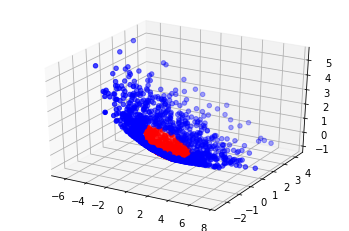

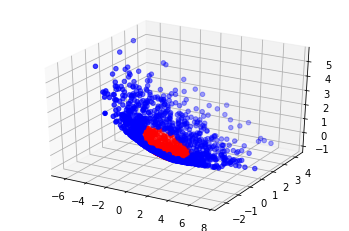

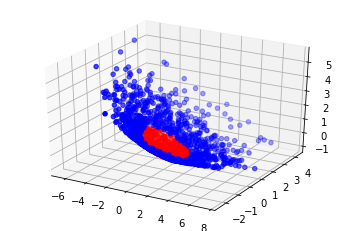

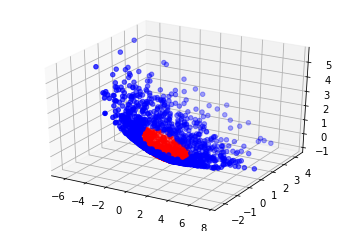

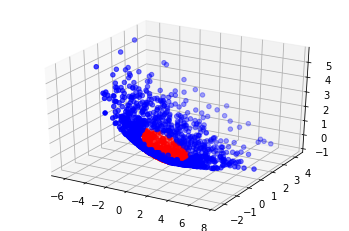

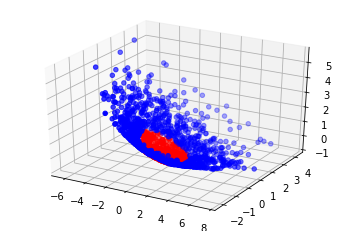

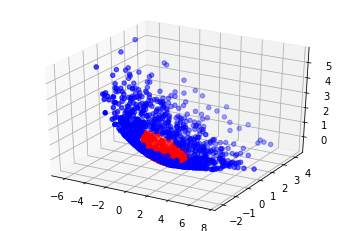

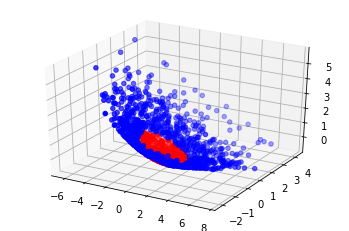

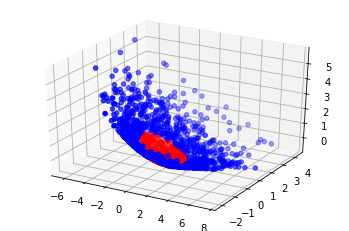

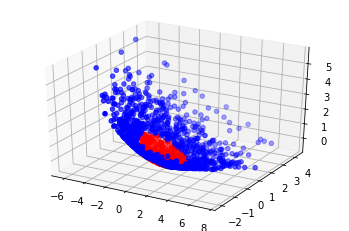

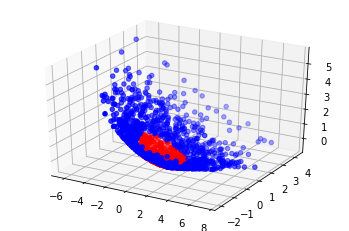

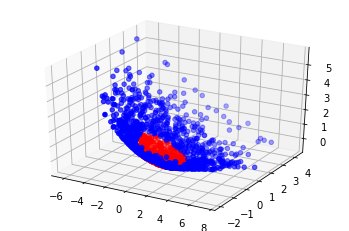

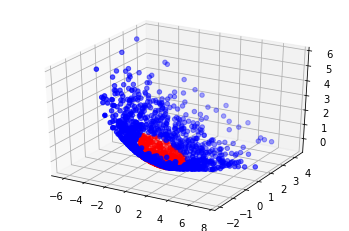

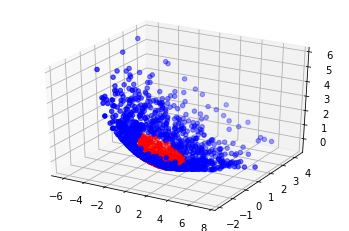

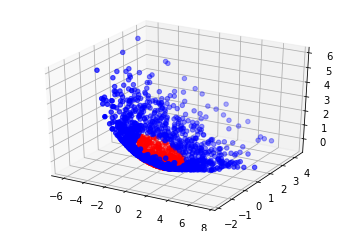

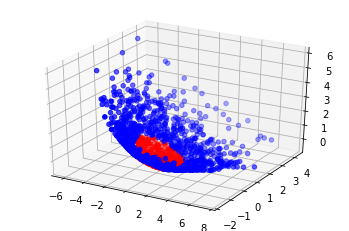

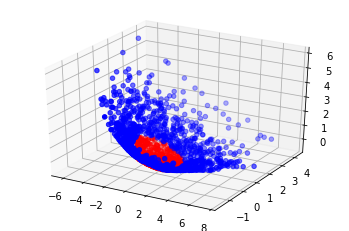

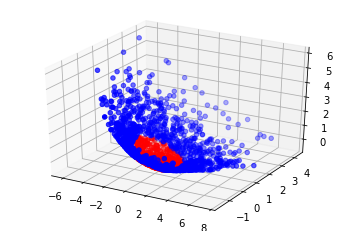

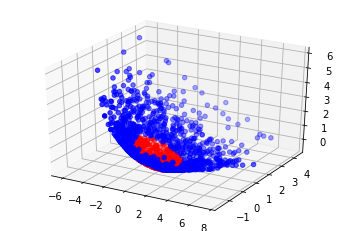

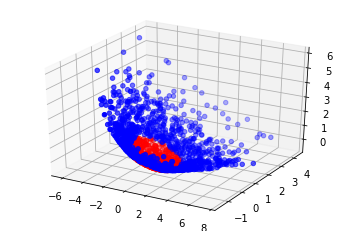

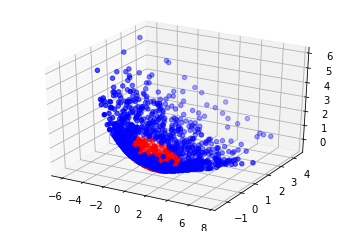

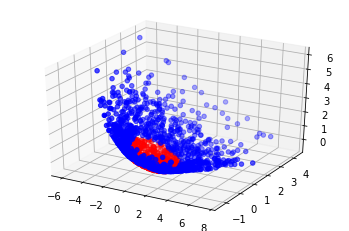

In [18]:
# plot the path
from mpl_toolkits.mplot3d import Axes3D

x,Xpath      = net(X,K0,K,b)

indRed   = (C==0).nonzero()
indBlue  = (C==1).nonzero()


for i in range(len(K)):
    Xi = Xpath[:,:,i].detach().numpy()    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Xi[0,indRed],Xi[1,indRed],Xi[2,indRed], c='r')
    ax.scatter(Xi[0,indBlue],Xi[1,indBlue],Xi[2,indBlue], c='b')

    plt.pause(0.1)